In [236]:
ALGORITHM = 'XG Boost'
ALGORITHM_DETAIL = 'random search'
DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

OVERRIDE_CV, OVERRIDE_N_ITER, OVERRIDE_JOBS = None, None, None

debug_mode = False
quick_mode = False
#quick_mode = True

if quick_mode:
    OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10


In [43]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

starter_pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    ('model', XGBRegressor(seed=20))
])

In [44]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

#confirm_colab = True
confirm_colab = False
IN_CLOUD = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB and not IN_CLOUD:
    from functions_20221109 import set_csv_directory, get_columns
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time, get_results, update_results

    set_csv_directory('final_split')
else:
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', 'zfunctions'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221109 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time, get_results, update_results


In [45]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [46]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [47]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../data/final/df_listings_v06.csv
(46871, 9)


In [48]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [49]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [50]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [51]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [52]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [53]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [54]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [55]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [56]:
fitted_graph_model = starter_pipe[-1]
default_model_params = fitted_graph_model.get_params()
default_model_params

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 20}

In [57]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [58]:
%timeit starter_pipe.fit(X_train, y_train)

3.35 s ± 600 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [372]:
options_block = {
    # 'base_score': None,
    # 'callbacks': None,
    # 'colsample_bylevel': None,
    # 'colsample_bynode': None,
    # 'colsample_bytree': None,
    # 'early_stopping_rounds': None,
    # 'enable_categorical': False,
    # 'eval_metric': None,
    # 'gpu_id': None,
    # 'grow_policy': None,
    # 'importance_type': None,
    # 'interaction_constraints': None,
    # 'max_bin': None,
    # 'max_cat_to_onehot': None,
    # 'max_leaves': None,
    ###'missing': nan,
    # 'monotone_constraints': None,
    # 'num_parallel_tree': None,
    # 'predictor': None,
    # 'random_state': None,
    # 'reg_alpha': None,
    # 'reg_lambda': None,
    # 'sampling_method': None,
    # 'scale_pos_weight': None,
    # 'tree_method': None,
    #'tree_method': ['auto', 'approx', 'hist', 'gpu_hist', 'exact'],
    # 'validate_parameters': None,

    'booster': ['gbtree','gblinear','dart'], # gbtree and dart use tree based models while gblinear uses linear functions.

    'n_estimators': [75, 50, 125, 100, 150], #100, 1000],


    ### For Tree Booster
    'tree_method': ['auto', 'approx', 'hist'], # pseudo optimsied, #, 'exact'], #, 'gpu_hist'],
    'learning_rate': [None], # pseudo optimised, also 0.3. Others: 0.01, 0.1, 0.2, 0.3, 0.4],
    'gamma': [None, 1,10,100,1000,10000,100000],
    'max_depth': [6, 1, 3, 10, 30],
    'min_child_weight': [1, 0.1, 0.5, 2, 5], # None,
    'max_delta_step': [0, 0.3, 0.1, 0.01, 0.9, 2.5], # None,
    'subsample': [1, 0, 0.1, 0.5], # None,

    'objective': 'reg:squarederror',

    'n_jobs': 3,
    #'verbosity': 3 if debug_mode else 2 if quick_mode else 1 #  Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug).
    'verbosity': 2
    }

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

def automl_step(param_options, vary):
    for key, value in param_options.items():
        #print(key, value, vary)
        if key != vary and key != 'model__' + vary:
            param_options[key] = [param_options[key][0]]
    return param_options

param_options = automl_step(param_options, vary='gamma')
print(f'cv={cv}, n_jobs={n_jobs}, refit={refit}, n_iter={n_iter}, verbose={verbose}')
param_options

cv=3, n_jobs=3, refit=True, n_iter=100, verbose=1


{'model__booster': ['gbtree'],
 'model__n_estimators': [75],
 'model__tree_method': ['auto'],
 'model__learning_rate': [None],
 'model__gamma': [None, 0, 0.3, 0.1, 0.01, 0.9, 2.5],
 'model__max_depth': [6],
 'model__min_child_weight': [1],
 'model__max_delta_step': [0],
 'model__subsample': [1],
 'model__objective': ['reg:squarederror'],
 'model__n_jobs': [3],
 'model__verbosity': [2]}

In [373]:
def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


crossval_runner = RandomizedSearchCV(
    estimator=starter_pipe,
    param_distributions=param_options,
    cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
    verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
    refit=refit,
    return_train_score=True, #n_iter=n_iter,
    n_iter=n_iter,  # 1, #3
    #error_score='raise'
)

cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
    crossval_runner, X_train, y_train, fits=cv * n_iter)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 7 is smaller than n_iter=100. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[20:31:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[20:31:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[20:31:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[20:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[20:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[20:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[20:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[20:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[20:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 prune

/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 7 is smaller than n_iter=100. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[20:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[20:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[20:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[20:36:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[20:36:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[20:36:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[20:36:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[20:36:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[20:36:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pru

In [374]:
crossval_runner.best_params_
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.6, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=75, n_jobs=3, num_parallel_tree=1,
                              predictor='auto', random_state=20, reg_alpha=0,
                              reg_lambda=0, ...))])

In [375]:
best_estimator_pipe = crossval_runner.best_estimator_

if debug_mode:
    crossval_runner.cv_results_

In [376]:
cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__verbosity,param_model__tree_method,param_model__subsample,param_model__objective,param_model__n_jobs,param_model__n_estimators,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,14.937919,0.283486,0.056055,0.012084,2,auto,1,reg:squarederror,3,75,...,0.654813,0.669161,0.662491,0.0059,1,0.755078,0.750555,0.754373,0.753335,0.001987
1,22.191820,5.835708,0.092944,0.020252,2,auto,1,reg:squarederror,3,75,...,0.654813,0.669161,0.662491,0.0059,1,0.755078,0.750555,0.754373,0.753335,0.001987
2,22.168443,2.788196,0.081888,0.026316,2,auto,1,reg:squarederror,3,75,...,0.654813,0.669161,0.662491,0.0059,1,0.755078,0.750555,0.754373,0.753335,0.001987
3,19.679271,1.163070,0.052793,0.007719,2,auto,1,reg:squarederror,3,75,...,0.654813,0.669161,0.662491,0.0059,1,0.755078,0.750555,0.754373,0.753335,0.001987
4,18.700713,3.348348,0.047726,0.005059,2,auto,1,reg:squarederror,3,75,...,0.654813,0.669161,0.662491,0.0059,1,0.755078,0.750555,0.754373,0.753335,0.001987
5,19.500578,5.737955,0.056957,0.015262,2,auto,1,reg:squarederror,3,75,...,0.654813,0.669161,0.662491,0.0059,1,0.755078,0.750555,0.754373,0.753335,0.001987
6,12.830645,4.763923,0.048248,0.029578,2,auto,1,reg:squarederror,3,75,...,0.654813,0.669161,0.662491,0.0059,1,0.755078,0.750555,0.754373,0.753335,0.001987


In [377]:

cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time','params']
# if 'Neural' not in ALGORITHM:
#     cv_columns.insert(2, 'mean_train_score')
cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)
cv_results_df_full_sorted

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,2/auto/1/reg:squarederror/3/75/1/6/0/None/None...,1,0.662491,14.937919,0.056055,"{'model__verbosity': 2, 'model__tree_method': ..."
1,2/auto/1/reg:squarederror/3/75/1/6/0/None/0/gb...,1,0.662491,22.191820,0.092944,"{'model__verbosity': 2, 'model__tree_method': ..."
2,2/auto/1/reg:squarederror/3/75/1/6/0/None/0.3/...,1,0.662491,22.168443,0.081888,"{'model__verbosity': 2, 'model__tree_method': ..."
3,2/auto/1/reg:squarederror/3/75/1/6/0/None/0.1/...,1,0.662491,19.679271,0.052793,"{'model__verbosity': 2, 'model__tree_method': ..."
4,2/auto/1/reg:squarederror/3/75/1/6/0/None/0.01...,1,0.662491,18.700713,0.047726,"{'model__verbosity': 2, 'model__tree_method': ..."
5,2/auto/1/reg:squarederror/3/75/1/6/0/None/0.9/...,1,0.662491,19.500578,0.056957,"{'model__verbosity': 2, 'model__tree_method': ..."
6,2/auto/1/reg:squarederror/3/75/1/6/0/None/2.5/...,1,0.662491,12.830645,0.048248,"{'model__verbosity': 2, 'model__tree_method': ..."


In [378]:
cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
    print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
    total_fits = len(cv_results_df_sorted)
cv_results_df_sorted


,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,2/auto/1/reg:squarederror/3/75/1/6/0/None/None...,1,0.662491,14.937919,0.056055,"{'model__verbosity': 2, 'model__tree_method': ..."
1,2/auto/1/reg:squarederror/3/75/1/6/0/None/0/gb...,1,0.662491,22.191820,0.092944,"{'model__verbosity': 2, 'model__tree_method': ..."
2,2/auto/1/reg:squarederror/3/75/1/6/0/None/0.3/...,1,0.662491,22.168443,0.081888,"{'model__verbosity': 2, 'model__tree_method': ..."
3,2/auto/1/reg:squarederror/3/75/1/6/0/None/0.1/...,1,0.662491,19.679271,0.052793,"{'model__verbosity': 2, 'model__tree_method': ..."
4,2/auto/1/reg:squarederror/3/75/1/6/0/None/0.01...,1,0.662491,18.700713,0.047726,"{'model__verbosity': 2, 'model__tree_method': ..."
5,2/auto/1/reg:squarederror/3/75/1/6/0/None/0.9/...,1,0.662491,19.500578,0.056957,"{'model__verbosity': 2, 'model__tree_method': ..."
6,2/auto/1/reg:squarederror/3/75/1/6/0/None/2.5/...,1,0.662491,12.830645,0.048248,"{'model__verbosity': 2, 'model__tree_method': ..."


In [379]:
def print_results(cross_validation_result):
    means = cross_validation_result.cv_results_['mean_test_score']
    stds = cross_validation_result.cv_results_['std_test_score']
    params = cross_validation_result.cv_results_['params']
    times = cross_validation_result.cv_results_['std_test_score']

    print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
    print()
    for mean, std, param, time in zip(means, stds, params, times):
        #param2 = "/".join(list(param.values()))
        param2 = "/".join(list([str(c) for c in param.values()]))
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


if debug_mode:
    print_results(crossval_runner)

In [380]:
print('Best Index: ', crossval_runner.best_index_)
print('Best Score: ', crossval_runner.best_score_)
print('Best Params: ', crossval_runner.best_params_)

Best Index:  0
Best Score:  0.6624907197654966
Best Params:  {'model__verbosity': 2, 'model__tree_method': 'auto', 'model__subsample': 1, 'model__objective': 'reg:squarederror', 'model__n_jobs': 3, 'model__n_estimators': 75, 'model__min_child_weight': 1, 'model__max_depth': 6, 'model__max_delta_step': 0, 'model__learning_rate': None, 'model__gamma': None, 'model__booster': 'gbtree'}


In [381]:
y_pred = best_estimator_pipe.predict(X_test)

In [382]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------XG Boost----------
R square Accuracy 0.6735780392790531
Mean Absolute Error Accuracy 47171.67821280874
Mean Squared Error Accuracy 3687394874.4554405
Root Mean Squared Error 60723.9234112507


In [383]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [384]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,346722.31250,53277.68750,13.319422,15.366097
119328242,369950.0,436349.28125,66399.28125,17.948177,15.217003
125716790,350000.0,337093.28125,12906.71875,3.687634,3.828827
122440040,549000.0,509273.96875,39726.03125,7.236071,7.800523
120508103,495000.0,508591.25000,13591.25000,2.745707,2.672333
...,...,...,...,...,...
68620869,475000.0,571690.43750,96690.43750,20.355882,16.913076
85735665,575000.0,442818.90625,132181.09375,22.988016,29.849921
125706338,400000.0,358196.25000,41803.75000,10.450938,11.670627


In [385]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted','actual','Price','bedrooms','bathrooms']] = combined[['predicted','actual','Price','bedrooms','bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160000,512783,352783.75000,220.489844,68.797763,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
109722224,108000,304242,196242.65625,181.706163,64.502019,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
85667184,122000,331653,209653.75000,171.847336,63.214648,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
83639617,190000,436570,246570.56250,129.773980,56.478971,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
122821142,170000,360516,190516.75000,112.068676,52.845464,170000,2,1,0.093936,51.430690,0.024020,0.069030,0.128440,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85204119,345000,345095,95.71875,0.027745,0.027737,345000,1,1,0.370728,51.510625,-0.327561,0.010905,0.223141,LEASEHOLD
125315948,225000,225050,50.56250,0.022472,0.022467,225000,1,1,0.503861,51.477531,-0.372533,0.022189,0.268113,LEASEHOLD
123809945,450000,450090,90.18750,0.020042,0.020038,450000,2,1,0.414807,51.435270,-0.094040,0.064450,0.010380,SHARE_OF_FREEHOLD
123126977,400000,400056,56.71875,0.014180,0.014178,400000,2,1,0.716265,51.490630,-0.031810,0.009090,0.072610,LEASEHOLD


In [386]:
score = best_estimator_pipe.score(X_test, y_test)
score

0.6735780392790531

In [387]:
r2_score(y_test, y_pred)

0.6735780392790531

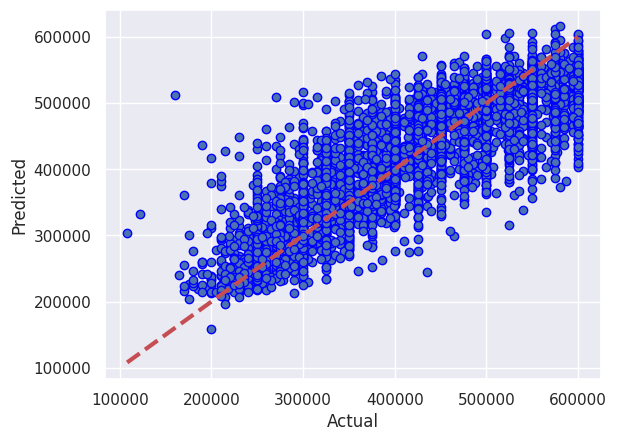

In [388]:
fig, ax = plt.subplots()
ax.scatter(y_test, best_estimator_pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [389]:
def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
    graph_model = model
    graph_model.set_params(**graph_params)
    graph_model.fit(X_train, y_train)
    y_pred_graph = model.predict(X_test)

    return model, y_pred_graph


best_model_count = 10 if not quick_mode else 2
best_model_count = 3 if not quick_mode else 1
best_models = {}
best_model_predictions = {}
best_model_scores = {}

showable_increment = total_fits // 4 if not quick_mode else 2
for i in range(0, total_fits, showable_increment):
    if debug_mode or True: print(f'{i} ==> {i}')

    if i == 0:
        fitted_graph_model = crossval_runner.best_estimator_
        y_pred_graph = y_pred
    else:
        graph_pipe_params = cv_results_df_sorted['params'][i]
        print (graph_pipe_params)
        # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

        graph_params = {}
        for key, value in graph_pipe_params.items():
            graph_params[key.replace('model__', '')] = value

        fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                        y_train, X_test)

    best_models[i] = fitted_graph_model[-1].get_params()
    best_model_predictions[i] = y_pred_graph
    best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

if debug_mode or True: print(f'{-1} ==> {-1}')
graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
print (graph_pipe_params)
graph_params = {}
for key, value in graph_pipe_params.items():
    graph_params[key.replace('model__', '')] = value
fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                y_train, X_test)
best_models[-1] = fitted_graph_model[-1].get_params()
best_model_predictions[-1] = y_pred_graph
best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
1 ==> 1
{'model__verbosity': 2, 'model__tree_method': 'auto', 'model__subsample': 1, 'model__objective': 'reg:squarederror', 'model__n_jobs': 3, 'model__n_estimators': 75, 'model__min_child_weight': 1, 'model__max_depth': 6, 'model__max_delta_step': 0, 'model__learning_rate': None, 'model__gamma': 0, 'model__booster': 'gbtree'}
[20:39:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:39:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:39:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:39:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:39:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:39:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 prun

In [390]:
cv_results_df_sorted

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,2/auto/1/reg:squarederror/3/75/1/6/0/None/None...,1,0.662491,14.937919,0.056055,"{'model__verbosity': 2, 'model__tree_method': ..."
1,2/auto/1/reg:squarederror/3/75/1/6/0/None/0/gb...,1,0.662491,22.191820,0.092944,"{'model__verbosity': 2, 'model__tree_method': ..."
2,2/auto/1/reg:squarederror/3/75/1/6/0/None/0.3/...,1,0.662491,22.168443,0.081888,"{'model__verbosity': 2, 'model__tree_method': ..."
3,2/auto/1/reg:squarederror/3/75/1/6/0/None/0.1/...,1,0.662491,19.679271,0.052793,"{'model__verbosity': 2, 'model__tree_method': ..."
4,2/auto/1/reg:squarederror/3/75/1/6/0/None/0.01...,1,0.662491,18.700713,0.047726,"{'model__verbosity': 2, 'model__tree_method': ..."
5,2/auto/1/reg:squarederror/3/75/1/6/0/None/0.9/...,1,0.662491,19.500578,0.056957,"{'model__verbosity': 2, 'model__tree_method': ..."
6,2/auto/1/reg:squarederror/3/75/1/6/0/None/2.5/...,1,0.662491,12.830645,0.048248,"{'model__verbosity': 2, 'model__tree_method': ..."


In [391]:
cv_results_df_sorted['params']

0    {'model__verbosity': 2, 'model__tree_method': ...
1    {'model__verbosity': 2, 'model__tree_method': ...
2    {'model__verbosity': 2, 'model__tree_method': ...
3    {'model__verbosity': 2, 'model__tree_method': ...
4    {'model__verbosity': 2, 'model__tree_method': ...
5    {'model__verbosity': 2, 'model__tree_method': ...
6    {'model__verbosity': 2, 'model__tree_method': ...
Name: params, dtype: object

In [392]:
total_fits

7

In [393]:
best_models

{0: {'objective': 'reg:squarederror',
  'base_score': 0.5,
  'booster': 'gbtree',
  'callbacks': None,
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'colsample_bytree': 1,
  'early_stopping_rounds': None,
  'enable_categorical': False,
  'eval_metric': None,
  'gamma': 0,
  'gpu_id': -1,
  'grow_policy': 'depthwise',
  'importance_type': None,
  'interaction_constraints': '',
  'learning_rate': 0.300000012,
  'max_bin': 256,
  'max_cat_to_onehot': 4,
  'max_delta_step': 0,
  'max_depth': 6,
  'max_leaves': 0,
  'min_child_weight': 1,
  'missing': nan,
  'monotone_constraints': '()',
  'n_estimators': 75,
  'n_jobs': 3,
  'num_parallel_tree': 1,
  'predictor': 'auto',
  'random_state': 20,
  'reg_alpha': 0,
  'reg_lambda': 0,
  'sampling_method': 'uniform',
  'scale_pos_weight': 1,
  'subsample': 1,
  'tree_method': 'auto',
  'validate_parameters': 1,
  'verbosity': 2,
  'seed': 20},
 1: {'objective': 'reg:squarederror',
  'base_score': 0.5,
  'booster': 'gbtree',
  'callbacks': 

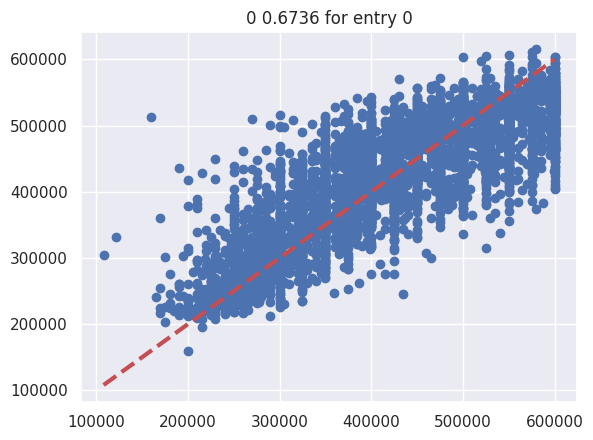

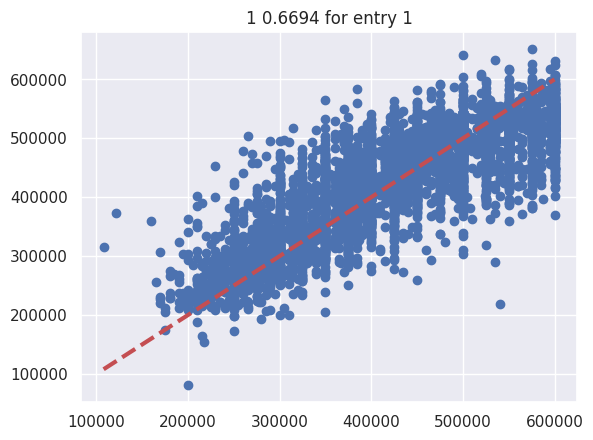

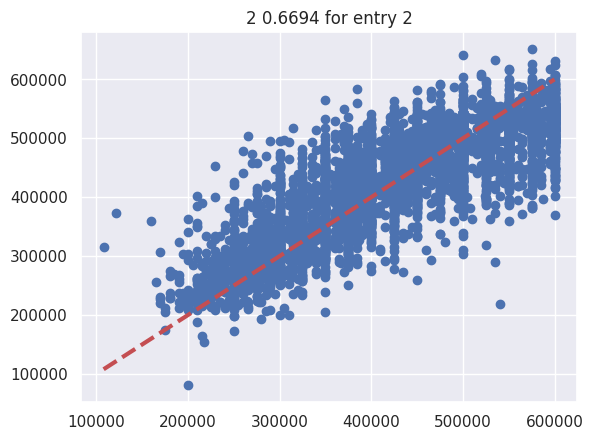

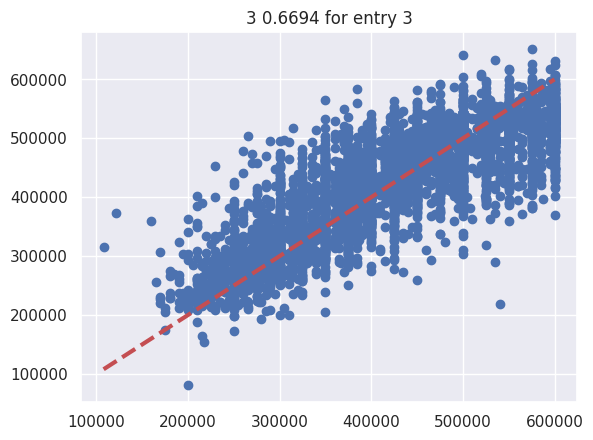

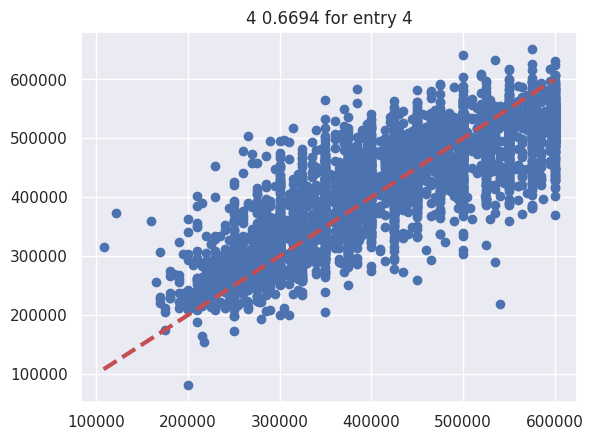

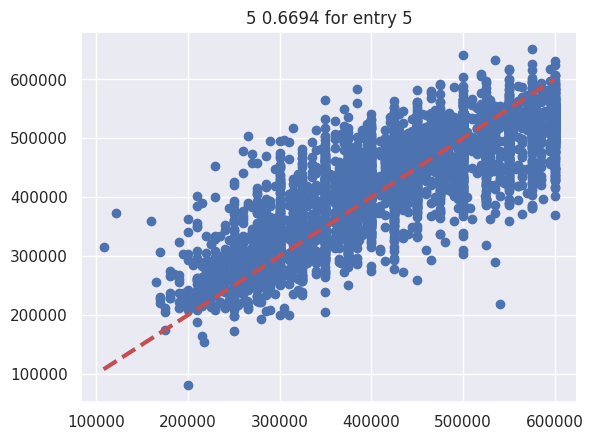

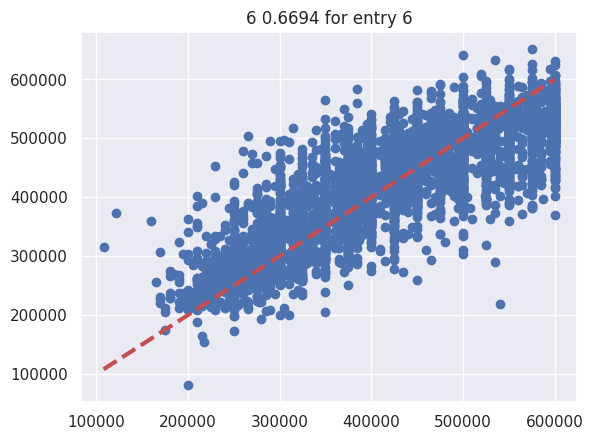

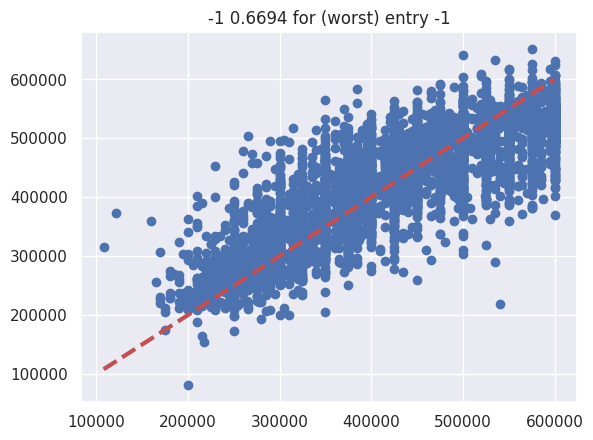

In [394]:
for i in best_model_scores.keys():
    if i >= 0:
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
        plt.scatter(y_test, best_model_predictions[i])
        # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
        plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
        plt.show()

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.scatter(y_test, best_model_predictions[-1])
# plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))
plt.show()

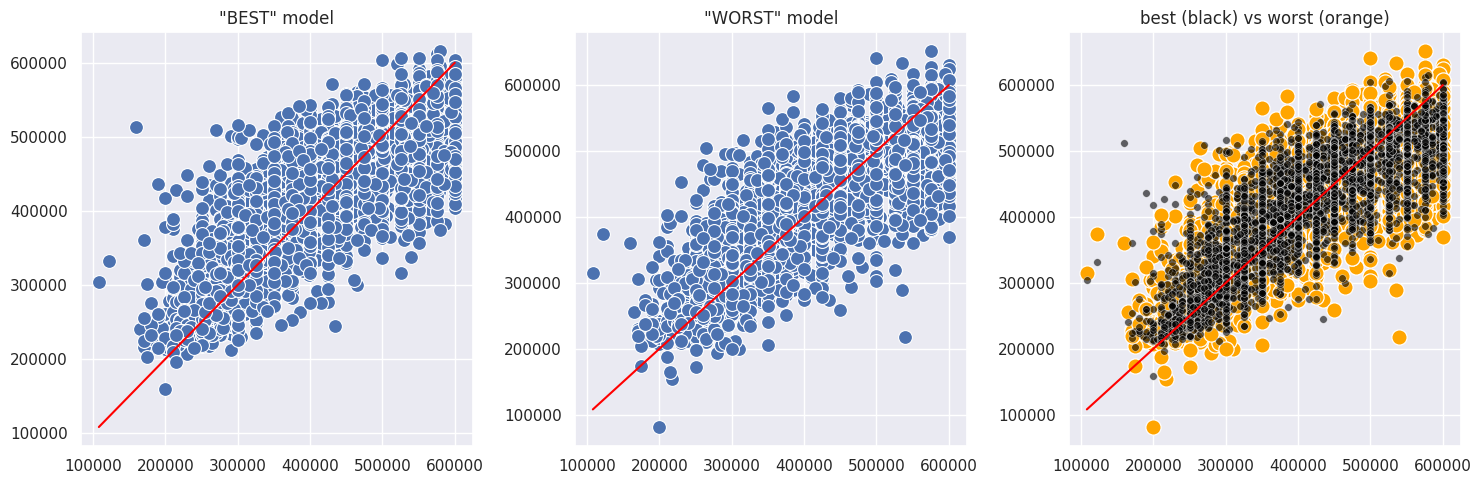

In [395]:
if True:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [396]:
cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
#cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time

14.9379190603892

In [397]:
cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]

DD2 = "(".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} - {ALGORITHM_DETAIL}{DD2} (v{VERSION})'.lower()

results = {
    'Score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    'Training Time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    'params': crossval_runner.best_params_
}

if not IN_COLAB:
    results_json = get_results()
    update_results(results_json, results, key)

print(key)
results

xg boost - random search (v06)


{'Score': 0.6735780392790531,
 'R square Accuracy': 0.6735780392790531,
 'Mean Absolute Error Accuracy': 47171.67821280874,
 'Mean Squared Error Accuracy': 3687394874.4554405,
 'Root Mean Squared Error': 60723.9234112507,
 'Training Time': 14.9379190603892,
 'random_state': 101,
 'date': '2022-11-11 20:39:42.843566',
 'params': {'model__verbosity': 2,
  'model__tree_method': 'auto',
  'model__subsample': 1,
  'model__objective': 'reg:squarederror',
  'model__n_jobs': 3,
  'model__n_estimators': 75,
  'model__min_child_weight': 1,
  'model__max_depth': 6,
  'model__max_delta_step': 0,
  'model__learning_rate': None,
  'model__gamma': None,
  'model__booster': 'gbtree'},
 'first run': '2022-11-06 22:13:02.393884',
 'best params': {'model__booster': 'gbtree',
  'model__gamma': None,
  'model__learning_rate': None,
  'model__max_delta_step': 0,
  'model__max_depth': 6,
  'model__min_child_weight': 1,
  'model__n_estimators': 75,
  'model__n_jobs': 3,
  'model__objective': 'reg:squarederror

In [398]:
crossval_runner.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=75, n_jobs=3, num_parallel_tree=1,
                              predictor='auto', random_state=20, reg_alpha=0,
                              reg_lambda=0, ...))])

In [399]:
with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
    pickle.dump(crossval_runner.best_estimator_, f)

In [400]:
feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
#std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

indices = np.argsort(feature_importances)[::-1]

print('Feature Ranking:')

for f in range(X_train.shape[1]):
    print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
          df_features.columns[indices[f] + 1])


Feature Ranking:
1. features 9 (0.505773) tenure.tenureType_LEASEHOLD
2. features 0 (0.170257) bedrooms
3. features 1 (0.083798) bathrooms
4. features 5 (0.064233) latitude_deviation
5. features 8 (0.053638) tenure.tenureType_FREEHOLD
6. features 4 (0.048599) location.longitude
7. features 6 (0.035776) longitude_deviation
8. features 3 (0.019346) location.latitude
9. features 10 (0.007612) tenure.tenureType_SHARE_OF_FREEHOLD
10. features 2 (0.007381) nearestStation
11. features 7 (0.003585) tenure.tenureType_COMMONHOLD


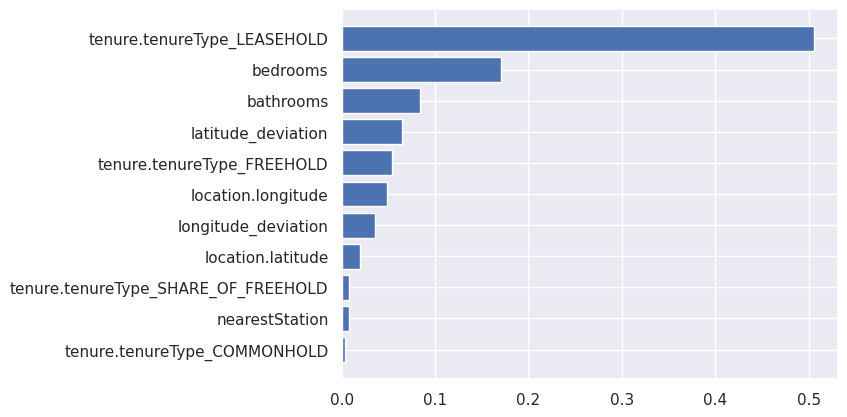

In [401]:
feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
indices = np.argsort(feature_importances)

fig, ax = plt.subplots()
ax.barh(range(len(feature_importances)), feature_importances[indices])
ax.set_yticks(range(len(feature_importances)))
_ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])